<a href="https://colab.research.google.com/github/MusinguziDenis/C-Programming-Assignment/blob/master/TrainingFacenetRemontada_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RE-TRAINING THE FACENET MODEL USING BLACK-FACES

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## The Arcface loss class

In [124]:
import math as m

import numpy as np
from tqdm import tqdm
import math
import os

import tensorflow as tf

import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Layer
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import layers
from tensorflow.keras import Model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [125]:
# Original paper: https://arxiv.org/pdf/1801.07698.pdf
# Original implementation: https://github.com/deepinsight/insightface
# Adapted from tensorflow implementation: https://github.com/luckycallor/InsightFace-tensorflow



class ArcFace(Layer):
    '''Custom Keras layer implementing ArcFace including:
    1. Generation of embeddings
    2. Loss function
    3. Accuracy function
    '''

    def __init__(self, output_dim, class_num, margin=0.5, scale=64., **kwargs):
        self.output_dim = output_dim
        self.class_num = class_num
        self.margin = margin
        self.s = scale

        self.cos_m = tf.math.cos(margin)
        self.sin_m = tf.math.sin(margin)
        self.mm = self.sin_m * margin
        self.threshold = tf.math.cos(tf.constant(m.pi) - margin)
        super(ArcFace, self).__init__(**kwargs)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'output_dim': self.output_dim,
            'class_num': self.class_num,
            'margin': self.margin,
            'scale': self.s
        })
        return config


    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.class_num),
                                      initializer='glorot_normal',
                                      trainable=True)
        super(ArcFace, self).build(input_shape)  # Be sure to call this at the end


    def call(self, x):
        embeddings = tf.nn.l2_normalize(x, axis=1, name='normed_embeddings')
        weights = tf.nn.l2_normalize(self.kernel, axis=0, name='normed_weights')
        cos_t = tf.matmul(embeddings, weights, name='cos_t')
        return cos_t


    def get_logits(self, labels, y_pred):
        cos_t = y_pred
        cos_t2 = tf.square(cos_t, name='cos_2')
        sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
        sin_t = tf.sqrt(sin_t2, name='sin_t')
        cos_mt = self.s * tf.subtract(tf.multiply(cos_t, self.cos_m), tf.multiply(sin_t, self.sin_m), name='cos_mt')
        cond_v = cos_t - self.threshold
        cond = tf.cast(tf.nn.relu(cond_v, name='if_else'), dtype=tf.bool)
        keep_val = self.s*(cos_t - self.mm)
        cos_mt_temp = tf.where(cond, cos_mt, keep_val)
        mask = tf.one_hot(labels, depth=self.class_num, name='one_hot_mask')
        inv_mask = tf.subtract(1., mask, name='inverse_mask')
        s_cos_t = tf.multiply(self.s, cos_t, name='scalar_cos_t')
        output = tf.add(tf.multiply(s_cos_t, inv_mask), tf.multiply(cos_mt_temp, mask), name='arcface_logits')
        return output


    def loss(self, y_true, y_pred):
        labels = K.argmax(y_true, axis=-1)
        logits = self.get_logits(labels, y_pred)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
        return loss


    def accuracy(self, y_true, y_pred):
        labels = K.argmax(y_true, axis=-1)
        logits = self.get_logits(labels, y_pred)
        accuracy = categorical_accuracy(y_true=labels, y_pred=logits)
        return accuracy
    

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)



In [126]:
import os
from os import listdir

path="/content/drive/MyDrive/Aligned/"
count=0
for f in listdir(path):
  count=0
  for nome in listdir(path+f):
    count+=1
  print("Name: ",f,"count: ",count)




Name:  Peterson count:  44
Name:  Vanny count:  30
Name:  Samson count:  64
Name:  Ruth count:  17
Name:  Salvador count:  35
Name:  Raymond count:  18
Name:  Remuneration count:  63
Name:  Renal count:  26
Name:  Sandra count:  35
Name:  Pesh count:  42
Name:  Mcvex count:  48
Name:  Owor count:  46
Name:  Onyango count:  36
Name:  Nabwiso count:  55
Name:  Ntale count:  37
Name:  Menk count:  52
Name:  Nduhukire count:  53
Name:  Namubiru count:  50
Name:  Mbonye count:  60
Name:  Nabata count:  46
Name:  Maritza count:  62
Name:  Lydia count:  71
Name:  Katatumba count:  61
Name:  KenMugabi count:  48
Name:  Lucky count:  57
Name:  Malaika count:  55
Name:  Maurice count:  32
Name:  Lynda count:  46
Name:  Marcus count:  43
Name:  Martha count:  38
Name:  Kabuura count:  23
Name:  Judithiana count:  50
Name:  Kabareebe count:  52
Name:  Julian count:  63
Name:  Karungi count:  41
Name:  Jazmine count:  51
Name:  Kanyomozi count:  77
Name:  GNL count:  25
Name:  Katamba count:  36
Na

In [127]:
import os
from os import listdir

path="/content/drive/MyDrive/AlignedVal/"
count=0
for f in listdir(path):
  count=0
  for nome in listdir(path+f):
    count+=1
  print("Name: ",f,"count: ",count)

Name:  Samson count:  21
Name:  Ruth count:  6
Name:  Raymond count:  4
Name:  Renal count:  7
Name:  Peterson count:  10
Name:  Salvador count:  8
Name:  Vanny count:  13
Name:  Sandra count:  9
Name:  Remuneration count:  19
Name:  Pesh count:  11
Name:  Owor count:  9
Name:  Menk count:  10
Name:  Nabwiso count:  19
Name:  Onyango count:  7
Name:  Mcvex count:  7
Name:  Namubiru count:  9
Name:  Mbonye count:  13
Name:  Nduhukire count:  8
Name:  Nabata count:  20
Name:  Ntale count:  8
Name:  Martha count:  6
Name:  Malaika count:  10
Name:  Maurice count:  6
Name:  Lydia count:  11
Name:  Lynda count:  7
Name:  Marcus count:  8
Name:  Lucky count:  16
Name:  Katatumba count:  19
Name:  KenMugabi count:  8
Name:  Maritza count:  12
Name:  Kanyomozi count:  12
Name:  Karungi count:  7
Name:  Kabuura count:  6
Name:  Kabareebe count:  9
Name:  Katamba count:  10
Name:  Judithiana count:  12
Name:  Julian count:  10
Name:  Jazmine count:  9
Name:  GNL count:  7
Name:  Kansiime count: 

#### Setting up the Image Data Generator API

In [128]:
#Import shutil first, this package deletes ipnb_checkpoints files that create a ghost class
import shutil
#The next step is to delete every ipynb_checkpoints file created by colab
#shutil.rmtree("/tmp/training/.ipynb_checkpoints") #be careful with shutil.rmtree() because it deletes every tree in that path. In other words, do not make mistakes.
#shutil.rmtree("/tmp/testing/.ipynb_checkpoints")

#specify both the training and validation directories
TRAINING_DIR="/content/drive/MyDrive/Aligned/"
VALIDATION_DIR="/content/drive/MyDrive/AlignedVal/"

#Initialize Image Data Generator objects, and rescale the image 
training_datagen=ImageDataGenerator(rescale=1/255)
validation_datagen=ImageDataGenerator(rescale=1/255)

#Create the image generators that create the create the classes for all images uploaded
training_generator=training_datagen.flow_from_directory(TRAINING_DIR,
                                                        class_mode='categorical',
                                                        target_size=(160,160), 
                                                        shuffle=False)
                                                        #save_to_dir ='/content/drive/MyDrive/Dataset/Augmented',
                                                        #save_prefix = "a",
                                                        #save_format = "png")
validation_generator=validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                            class_mode='categorical',
                                                            target_size=(160,160), 
                                                            shuffle=False, 
                                                            batch_size=1)#,
                                                            #save_to_dir ='/content/drive/MyDrive/Extracted/Augmented',
                                                            #save_prefix = "a",
                                                            #save_format = "png"
                                                          #)

#Load the facenet model architecture
#model=load_model('/tmp/facenet/facenet_keras.h5')


Found 2659 images belonging to 59 classes.
Found 603 images belonging to 59 classes.


## Loading the facenet Model architecture

In [129]:
model=load_model('/content/drive/MyDrive/facenet_keras (1).hdf5')
#A summary of the model architecture
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [130]:
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  426


In [131]:
local_weights_file='/content/drive/MyDrive/weightss/facenet_keras_weights.hdf5'
model.load_weights(local_weights_file)

for layer in model.layers:
  layer.trainable=False

In [132]:
#Specify the last layer from the architecture, that you actually want
last_layer=model.get_layer('Bottleneck')
last_output=last_layer.output

In [133]:
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [134]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=20)

In [135]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001)

In [136]:
checkpoint_filepath= '/content/drive/MyDrive/Dataset/Model/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_filepath.format(epoch=0))

In [137]:
#Code from arcface repo

#customizable arcface layer
af_layer = ArcFace(output_dim=128, class_num=128, margin=0.5, scale=64.)

arcface_output = af_layer(last_output)
x=layers.Flatten()(arcface_output)
#print(arcface_output)
x = Dropout(rate=0.3)(x)

x=layers.Dense(1024,activation='relu')(x)

x=layers.Dense(512,activation='relu')(x)
x = Dropout(rate=0.5)(x)
x=layers.Dense(128,activation='relu')(x)
x=layers.Dense(59,activation='softmax')(x)

model=Model(model.input,x)
model.compile(optimizer=RMSprop(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC(multi_label = True), tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [138]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
___________________________________________________________________________________________

In [140]:
#training for 100 epochs
history=model.fit(training_generator,validation_data=validation_generator,epochs=100,verbose=2, callbacks=[reduce_lr,early])

Epoch 1/100
84/84 - 16s - loss: 0.4889 - accuracy: 0.8755 - auc_12: 0.9950 - recall_12: 0.7973 - precision_12: 0.9460 - val_loss: 0.7645 - val_accuracy: 0.8574 - val_auc_12: 0.9879 - val_recall_12: 0.8043 - val_precision_12: 0.9547
Epoch 2/100
84/84 - 16s - loss: 0.5007 - accuracy: 0.8721 - auc_12: 0.9943 - recall_12: 0.7834 - precision_12: 0.9529 - val_loss: 0.7645 - val_accuracy: 0.8574 - val_auc_12: 0.9879 - val_recall_12: 0.8043 - val_precision_12: 0.9547
Epoch 3/100
84/84 - 16s - loss: 0.4985 - accuracy: 0.8699 - auc_12: 0.9950 - recall_12: 0.7924 - precision_12: 0.9465 - val_loss: 0.7642 - val_accuracy: 0.8574 - val_auc_12: 0.9878 - val_recall_12: 0.8043 - val_precision_12: 0.9547
Epoch 4/100
84/84 - 16s - loss: 0.4886 - accuracy: 0.8763 - auc_12: 0.9955 - recall_12: 0.7958 - precision_12: 0.9472 - val_loss: 0.7632 - val_accuracy: 0.8574 - val_auc_12: 0.9880 - val_recall_12: 0.8043 - val_precision_12: 0.9547
Epoch 5/100
84/84 - 16s - loss: 0.4982 - accuracy: 0.8680 - auc_12: 0.99

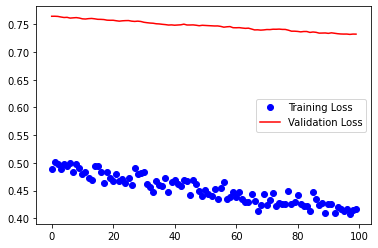

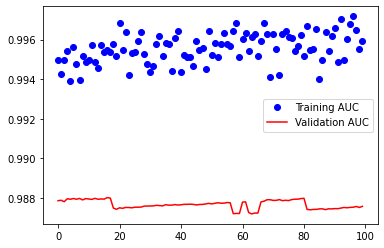

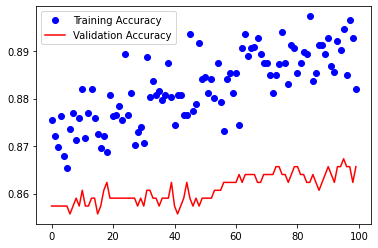

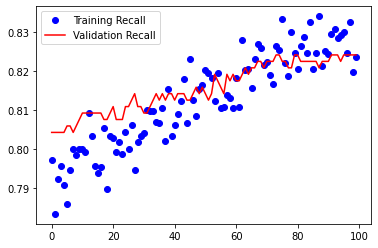

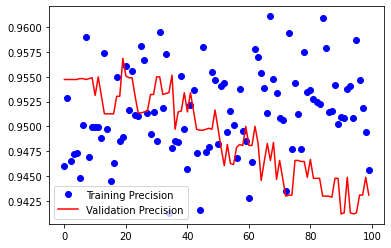

In [141]:
auc=history.history['auc_12']
val_auc=history.history['val_auc_12']

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

recall=history.history['recall_12']
val_recall=history.history['val_recall_12']

precision=history.history['precision_12']
val_precision=history.history['val_precision_12']

epochs=range(len(acc))

plt.plot(epochs,loss,'bo',label="Training Loss")
plt.plot(epochs,val_loss,'r',label="Validation Loss")
plt.legend()
plt.show()


plt.plot(epochs,auc,'bo',label="Training AUC")
plt.plot(epochs,val_auc,'r',label="Validation AUC")
plt.legend()
plt.figure()

plt.plot(epochs,acc,'bo',label="Training Accuracy")
plt.plot(epochs,val_acc,'r',label="Validation Accuracy")
plt.legend()
plt.show()

plt.plot(epochs,recall,'bo',label="Training Recall")
plt.plot(epochs,val_recall,'r',label="Validation Recall")
plt.legend()
plt.show()

plt.plot(epochs,precision,'bo',label="Training Precision")
plt.plot(epochs,val_precision,'r',label="Validation Precision")
plt.legend()
plt.show()

In [142]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [143]:
filenames = validation_generator.filenames
nb_samples = len(filenames)

In [144]:
predict = model.predict_generator(validation_generator,steps = nb_samples)
y_pred = np.argmax(predict, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [145]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[10  0  0 ...  0  0  0]
 [ 0  4  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ... 21  0  0]
 [ 0  0  0 ...  0  7  0]
 [ 0  0  0 ...  0  0  6]]


In [146]:
target_names=list(training_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Abenaki       1.00      1.00      1.00        10
        Alex       1.00      1.00      1.00         4
       Aloyo       1.00      0.83      0.91        12
       Apass       1.00      0.86      0.92         7
  Babygloria       0.88      0.78      0.82         9
      Barbie       1.00      0.67      0.80         3
       Becky       1.00      1.00      1.00        10
     Bettina       1.00      0.79      0.88        14
       Brian       0.83      1.00      0.91         5
      Canary       1.00      0.94      0.97        16
       Cindy       0.88      0.94      0.91        16
   Cleopatra       1.00      0.90      0.95        10
      Daniel       1.00      1.00      1.00        17
      Desire       0.95      1.00      0.98        21
       Diana       0.45      1.00      0.62         9
     Dorothy       1.00      0.33      0.50         3
       Farid       0.89      0.94      0.91        17
         GNL       0.78    

In [147]:
!pip install scikit-plot

In [148]:
import scikitplot as skplt
plt.figure(figsize=(20, 20))

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

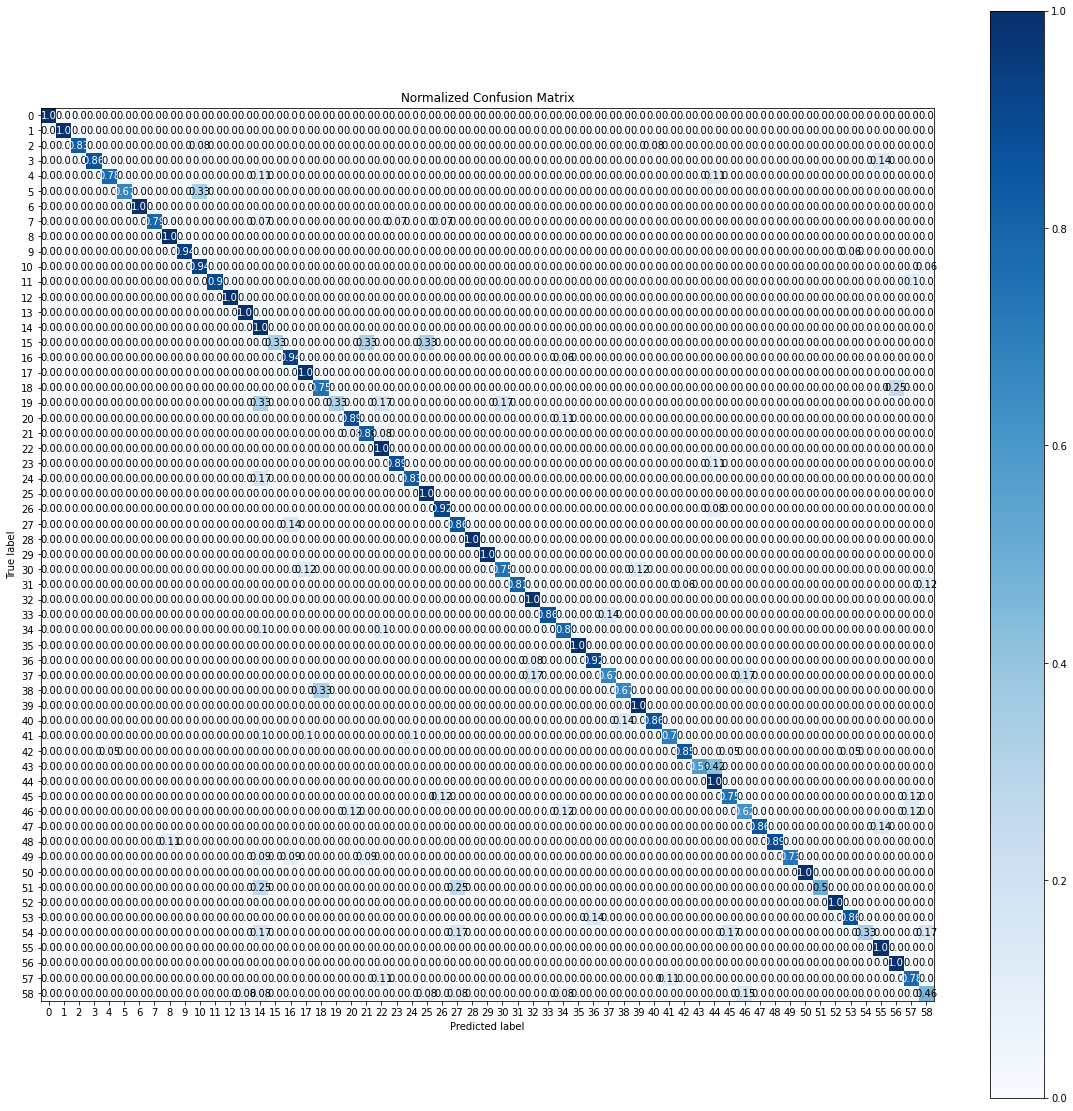

<Figure size 1440x1440 with 0 Axes>

In [149]:
fig, ax = plt.subplots(figsize=(20, 20))
skplt.metrics.plot_confusion_matrix(validation_generator.classes, y_pred, normalize=True,ax=ax)
plt.figure(figsize=(20, 20))
plt.show()

In [ ]:
os.listdir(checkpoint_dir)

['cp-0170.ckpt.index',
 'cp-0171.ckpt.data-00000-of-00001',
 'cp-0171.ckpt.index',
 'cp-0172.ckpt.data-00000-of-00001',
 'cp-0172.ckpt.index',
 'cp-0173.ckpt.data-00000-of-00001',
 'cp-0173.ckpt.index',
 'cp-0174.ckpt.data-00000-of-00001',
 'cp-0174.ckpt.index',
 'cp-0175.ckpt.data-00000-of-00001',
 'cp-0175.ckpt.index',
 'checkpoint (1)',
 'cp-0176.ckpt.data-00000-of-00001',
 'cp-0176.ckpt.index',
 'cp-0177.ckpt.data-00000-of-00001',
 'cp-0177.ckpt.index',
 'cp-0178.ckpt.index',
 'cp-0179.ckpt.index',
 'cp-0180.ckpt.index',
 'cp-0181.ckpt.index',
 'cp-0182.ckpt.index',
 'cp-0183.ckpt.index',
 'cp-0184.ckpt.index',
 'cp-0185.ckpt.index',
 'cp-0186.ckpt.index',
 'cp-0187.ckpt.index',
 'cp-0188.ckpt.index',
 'cp-0189.ckpt.index',
 'cp-0190.ckpt.index',
 'cp-0191.ckpt.index',
 'cp-0192.ckpt.index',
 'cp-0193.ckpt.index',
 'cp-0194.ckpt.index',
 'cp-0195.ckpt.index',
 'cp-0196.ckpt.index',
 'cp-0197.ckpt.index',
 'cp-0198.ckpt.index',
 'cp-0199.ckpt.index',
 'cp-0200.ckpt.index',
 'cp-0000

In [ ]:
#latest = tf.train.latest_checkpoint(checkpoint_dir)
latest='/content/drive/MyDrive/Dataset/Model/cp-0177.ckpt'

In [ ]:
# Load the previously saved weights
model.load_weights(latest)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
____________________________________________________________________________________________

In [ ]:
acc = model.evaluate(validation_generator, verbose=2)

603/603 - 50s - loss: 0.8422 - accuracy: 0.8955 - auc_2: 0.9882 - recall_2: 0.6932 - precision_2: 0.9835


In [ ]:
#training for 200 epochs
history=model.fit(training_generator,validation_data=validation_generator,epochs=200,verbose=2, callbacks=[reduce_lr,early,model_checkpoint_callback])

Epoch 1/200
84/84 - 644s - loss: 0.5986 - accuracy: 0.9425 - auc_1: 0.9954 - recall_1: 0.7732 - precision_1: 1.0000 - val_loss: 0.9158 - val_accuracy: 0.8773 - val_auc_1: 0.9881 - val_recall_1: 0.6235 - val_precision_1: 0.9973
Epoch 2/200
84/84 - 17s - loss: 0.5995 - accuracy: 0.9417 - auc_1: 0.9947 - recall_1: 0.7736 - precision_1: 1.0000 - val_loss: 0.9154 - val_accuracy: 0.8773 - val_auc_1: 0.9881 - val_recall_1: 0.6252 - val_precision_1: 0.9974
Epoch 3/200
84/84 - 17s - loss: 0.5982 - accuracy: 0.9436 - auc_1: 0.9952 - recall_1: 0.7736 - precision_1: 1.0000 - val_loss: 0.9150 - val_accuracy: 0.8773 - val_auc_1: 0.9881 - val_recall_1: 0.6252 - val_precision_1: 0.9974
Epoch 4/200
84/84 - 17s - loss: 0.5967 - accuracy: 0.9417 - auc_1: 0.9949 - recall_1: 0.7736 - precision_1: 1.0000 - val_loss: 0.9146 - val_accuracy: 0.8773 - val_auc_1: 0.9881 - val_recall_1: 0.6252 - val_precision_1: 0.9974
Epoch 5/200
84/84 - 17s - loss: 0.5961 - accuracy: 0.9421 - auc_1: 0.9954 - recall_1: 0.7744 - 

In [ ]:
#latest = tf.train.latest_checkpoint(checkpoint_dir)
latest='/content/drive/MyDrive/Dataset/Model/cp-0200.ckpt'

'/content/drive/MyDrive/Dataset/Model/cp-0200.ckpt'

In [ ]:
# Load the previously saved weights
model.load_weights(latest)

In [ ]:
acc = model.evaluate(validation_generator, verbose=2)

603/603 - 10s - loss: 0.8636 - accuracy: 0.8939 - auc_1: 0.9882 - recall_1: 0.6700 - precision_1: 0.9902


In [ ]:
#training for 200 epochs
history=model.fit(training_generator,validation_data=validation_generator,epochs=200,verbose=2, callbacks=[reduce_lr,early,model_checkpoint_callback])

Epoch 1/200
84/84 - 16s - loss: 0.5376 - accuracy: 0.9519 - auc_1: 0.9956 - recall_1: 0.8289 - precision_1: 1.0000 - val_loss: 0.8635 - val_accuracy: 0.8939 - val_auc_1: 0.9882 - val_recall_1: 0.6700 - val_precision_1: 0.9902
Epoch 2/200
84/84 - 17s - loss: 0.5375 - accuracy: 0.9534 - auc_1: 0.9956 - recall_1: 0.8285 - precision_1: 1.0000 - val_loss: 0.8633 - val_accuracy: 0.8939 - val_auc_1: 0.9882 - val_recall_1: 0.6700 - val_precision_1: 0.9902
Epoch 3/200
84/84 - 16s - loss: 0.5374 - accuracy: 0.9519 - auc_1: 0.9956 - recall_1: 0.8278 - precision_1: 1.0000 - val_loss: 0.8632 - val_accuracy: 0.8939 - val_auc_1: 0.9884 - val_recall_1: 0.6700 - val_precision_1: 0.9902
Epoch 4/200
84/84 - 17s - loss: 0.5369 - accuracy: 0.9526 - auc_1: 0.9957 - recall_1: 0.8278 - precision_1: 1.0000 - val_loss: 0.8630 - val_accuracy: 0.8939 - val_auc_1: 0.9884 - val_recall_1: 0.6700 - val_precision_1: 0.9902
Epoch 5/200
84/84 - 17s - loss: 0.5376 - accuracy: 0.9511 - auc_1: 0.9957 - recall_1: 0.8300 - p

### Lets visualize the output of the training phase

## 413 from 426

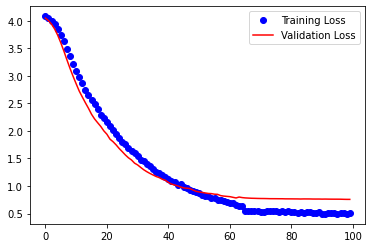

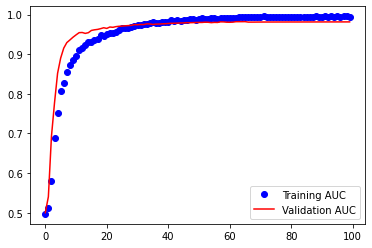

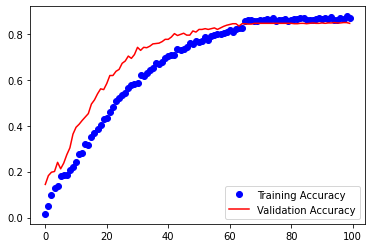

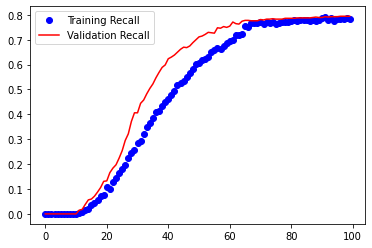

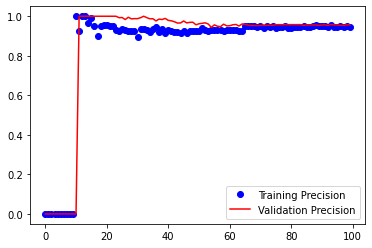

In [22]:
auc=history.history['auc_2']
val_auc=history.history['val_auc_2']

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

recall=history.history['recall_2']
val_recall=history.history['val_recall_2']

precision=history.history['precision_2']
val_precision=history.history['val_precision_2']

epochs=range(len(acc))

plt.plot(epochs,loss,'bo',label="Training Loss")
plt.plot(epochs,val_loss,'r',label="Validation Loss")
plt.legend()
plt.show()


plt.plot(epochs,auc,'bo',label="Training AUC")
plt.plot(epochs,val_auc,'r',label="Validation AUC")
plt.legend()
plt.figure()

plt.plot(epochs,acc,'bo',label="Training Accuracy")
plt.plot(epochs,val_acc,'r',label="Validation Accuracy")
plt.legend()
plt.show()

plt.plot(epochs,recall,'bo',label="Training Recall")
plt.plot(epochs,val_recall,'r',label="Validation Recall")
plt.legend()
plt.show()

plt.plot(epochs,precision,'bo',label="Training Precision")
plt.plot(epochs,val_precision,'r',label="Validation Precision")
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [24]:
filenames = validation_generator.filenames
nb_samples = len(filenames)

In [25]:
predict = model.predict_generator(validation_generator,steps = nb_samples)
y_pred = np.argmax(predict, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [26]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[10  0  0 ...  0  0  0]
 [ 0  4  0 ...  0  0  0]
 [ 0  0  9 ...  0  1  0]
 ...
 [ 0  0  0 ... 21  0  0]
 [ 0  0  0 ...  0  2  0]
 [ 0  0  0 ...  0  0  7]]


In [27]:
target_names=list(training_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Abenaki       0.83      1.00      0.91        10
        Alex       1.00      1.00      1.00         4
       Aloyo       0.90      0.75      0.82        12
       Apass       1.00      1.00      1.00         7
  Babygloria       0.80      0.89      0.84         9
      Barbie       1.00      1.00      1.00         3
       Becky       1.00      1.00      1.00        10
     Bettina       0.85      0.79      0.81        14
       Brian       0.67      0.80      0.73         5
      Canary       1.00      0.94      0.97        16
       Cindy       1.00      0.81      0.90        16
   Cleopatra       0.88      0.70      0.78        10
      Daniel       1.00      1.00      1.00        17
      Desire       0.95      1.00      0.98        21
       Diana       0.50      1.00      0.67         9
     Dorothy       0.00      0.00      0.00         3
       Farid       0.94      0.94      0.94        17
         GNL       0.86    

In [28]:
!pip install scikit-plot

In [29]:
import scikitplot as skplt
plt.figure(figsize=(20, 20))

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

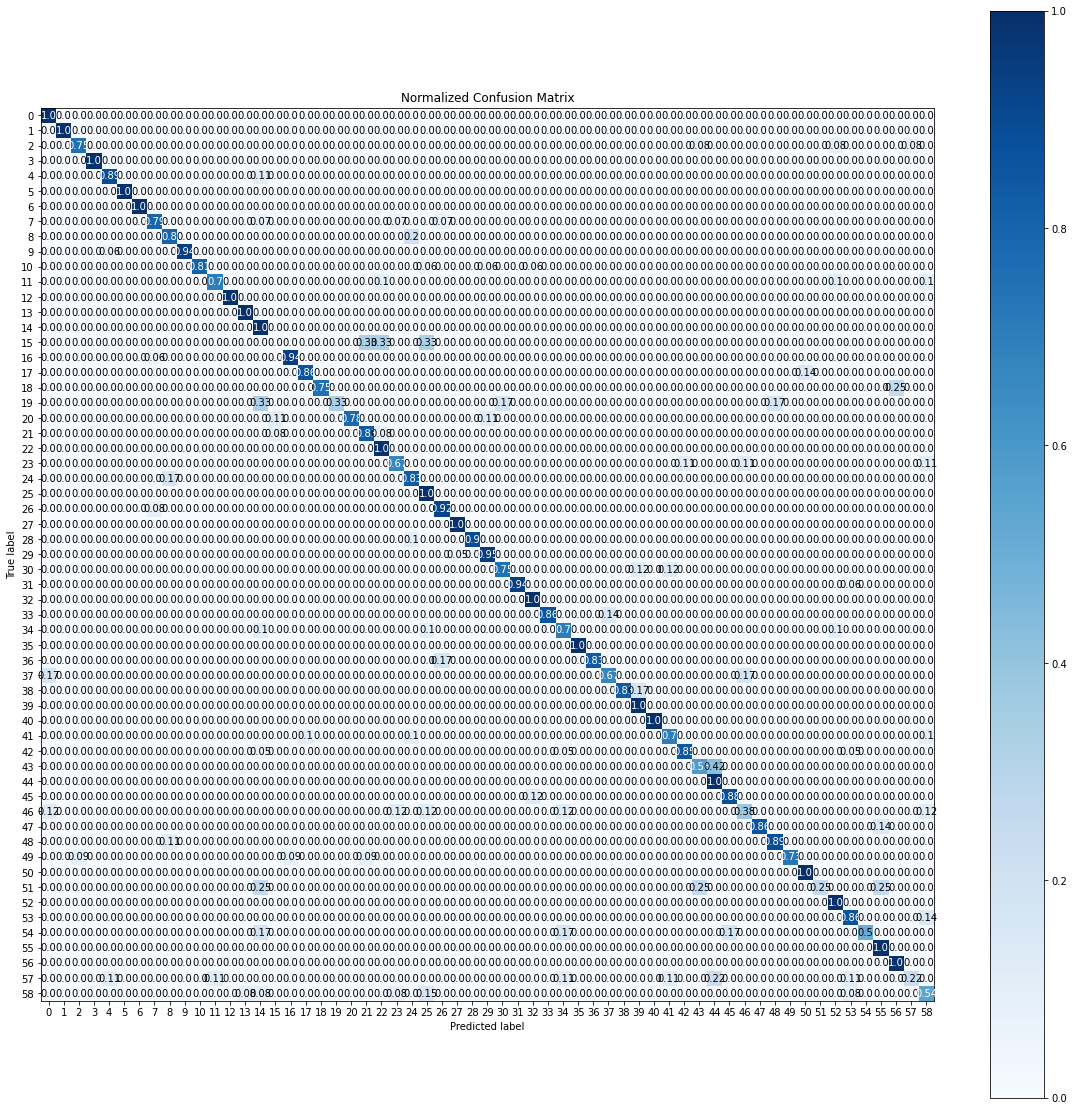

<Figure size 1440x1440 with 0 Axes>

In [30]:
fig, ax = plt.subplots(figsize=(20, 20))
skplt.metrics.plot_confusion_matrix(validation_generator.classes, y_pred, normalize=True,ax=ax)
plt.figure(figsize=(20, 20))
plt.show()

In [ ]:
title='Normalized confusion matrix'

In [ ]:
disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

In [ ]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
____________________________________________________________________________________________

In [ ]:
model2=Model(model.input,model.layers[-3].output)
model2.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
___________________________________________________________________________________________

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
sess=tf.Session()
from tensorflow.python.framework import graph_io
frozen = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, ["name_of_the_output_node"])
graph_io.write_graph(frozen, '/tmp/session-frozens', 'inference_graph.pb', as_text=False)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from keras import backend as K 
from keras.models import Sequential, Model


sess=tf.Session()
K.set_learning_phase(0)   # Set the learning phase to 0
model = model2 
config = model2.get_config()
#weights = model2.get_weights()
#model = Sequential.from_config(config)
output_node = model2.output.name.split(':')[0]  # We need this in the next step
graph_file = "kerasFacenet.pb" 
ckpt_file = "kerasFacenet.ckpt"
saver = tf.train.Saver(sharded=True)
tf.train.write_graph(sess.graph_def, '', graph_file)
#saver.save(sess, ckpt_file) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


'kerasFacenet.pb'

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

tf.saved_model.save(model2, "/tmp/saved-models")

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model2(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]
#print("-" * 50)
#print("Frozen model layers: ")
for layer in layers:
    print(layer)

#print("-" * 50)
#print("Frozen model inputs: ")
#print(frozen_func.inputs)
#print("Frozen model outputs: ")
#print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="/tmp/saved-model",
                  name="facenet-Original-LastLayer.pb",
                  as_text=False)


INFO:tensorflow:Assets written to: /tmp/saved-models/assets
x
model_12/Conv2d_1a_3x3/Conv2D/ReadVariableOp/resource
model_12/Conv2d_1a_3x3/Conv2D/ReadVariableOp
model_12/Conv2d_1a_3x3/Conv2D
model_12/Conv2d_1a_3x3_BatchNorm/scale
model_12/Conv2d_1a_3x3_BatchNorm/ReadVariableOp/resource
model_12/Conv2d_1a_3x3_BatchNorm/ReadVariableOp
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp/resource
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp_1/resource
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp_1
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3
model_12/Conv2d_1a_3x3_Activation/Relu
model_12/Conv2d_2a_3x3/Conv2D/ReadVariableOp/resource
model_12/Conv2d_2a_3x3/Conv2D/ReadVariableOp
model_12/Conv2d_2a_3x3/Conv2D
model_12/Conv2d_2a_3x3_BatchNorm/scale
model_12/Conv2d_2a_3x3_BatchNorm/ReadVariableOp/resource
model_12/Conv2d_2a_3x3_BatchNorm/ReadVariableOp
model_12/Conv2d_2a_3x

'/tmp/saved-model/facenet-Original-LastLayer.pb'

In [ ]:
loaded_model=load_model('/content/drive/MyDrive/my_model.h5', custom_objects={'ArcFace':ArcFace},compile=False)
#A summary of the model architecture
loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
____________________________________________________________________________________________

In [ ]:
last_layer=loaded_model.get_layer('arc_face')
last_output=last_layer.output

In [ ]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
______________________________________________________________________________________________

In [ ]:
new_model=Model(loaded_model.input,loaded_model.layers[-2].output)
new_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
____________________________________________________________________________________________

In [ ]:
import keras

from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

import matplotlib.pyplot as plt

In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(160, 160))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [ ]:
def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

"""def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))"""

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [ ]:
def displayImages(path1, path2):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(image.load_img(path1))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(image.load_img(path2))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)

In [ ]:
p1 = '/content/drive/MyDrive/Aligned/Lucky/PNG image 14_0.jpg'
p2 = '/content/drive/MyDrive/Extracted/Validation/Ruth/IMG_9101.PNG'
p3 = '/content/drive/MyDrive/Extracted/Validation/Samson/IMG_8652.PNG'
p4 = '/content/drive/MyDrive/Extracted/Validation/Canary/IMG_9265.PNG'
p5 = '/content/drive/MyDrive/Extracted/Validation/Becky/IMG_8312.PNG'
p6 = '/content/drive/MyDrive/Extracted/Validation/Nabata/IMG_8447.PNG'

In [ ]:
img1_representation = new_model.predict(preprocess_image(p1))[0,:]
img2_representation = new_model.predict(preprocess_image(p2))[0,:]
img3_representation = new_model.predict(preprocess_image(p3))[0,:]
img4_representation = new_model.predict(preprocess_image(p4))[0,:]
img5_representation = new_model.predict(preprocess_image(p5))[0,:]
img6_representation = new_model.predict(preprocess_image(p6))[0,:]

In [ ]:
img1_representation.shape

(128,)

In [ ]:
database = {}
database["Lucky"] = img1_representation
database["Ruth"] = img2_representation
database["Samson"] = img3_representation
database["Canary"] = img4_representation
database["Becky"] = img5_representation
database["Nabata"] = img6_representation

In [ ]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """
    
    ### START CODE HERE ###
    
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
    encoding = new_model.predict(preprocess_image(image_path))[0,:]
    
    # Step 2: Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(encoding - database[identity])
    
    # Step 3: Open the door if dist < 0.5, else don't open (≈ 3 lines)
    if dist < .5:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
        
    ### END CODE HERE ###
        
    return dist, door_open

In [ ]:
verify("/content/drive/MyDrive/AlignedVal/Mbonye/IMG_2279_0.jpg", "Canary", database, new_model)

It's not Canary, please go away


(0.7862337, False)

In [ ]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
    
    ### START CODE HERE ### 
    
    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding = new_model.predict(preprocess_image(image_path))[0,:]
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc from the database. (≈ 1 line)
        dist = np.linalg.norm(encoding - db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist < min_dist:
            min_dist = dist
            identity = name

    ### END CODE HERE ###
    
    if min_dist > 0.4:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

In [ ]:
who_is_it("/content/drive/MyDrive/Aligned/Becky/IMG_8347_0.jpg", database, new_model)

Not in the database.


(0.5217243, 'Samson')

In [ ]:
idendities = {
 "Abenaki": ["/content/drive/MyDrive/Aligned/Abenaki/IMG_1074_0.jpg", "/content/drive/MyDrive/Aligned/Abenaki/IMG_1079_0.jpg", "/content/drive/MyDrive/Aligned/Abenaki/IMG_1090_0.jpg"
 , "/content/drive/MyDrive/Aligned/Abenaki/IMG_1107_0.jpg", "/content/drive/MyDrive/Aligned/Abenaki/IMG_1119_0.jpg"],
 "Barbie": ["/content/drive/MyDrive/AlignedVal/Barbie/IMG_9750_0.jpg", "/content/drive/MyDrive/AlignedVal/Barbie/IMG_9781_0.jpg"],
 "Bettina": ["/content/drive/MyDrive/AlignedVal/Bettina/IMG_2314_0.jpg", "/content/drive/MyDrive/AlignedVal/Bettina/IMG_2346_0.jpg"],
 "Canary": ["/content/drive/MyDrive/AlignedVal/Canary/IMG_9256_0.jpg", "/content/drive/MyDrive/AlignedVal/Canary/IMG_9273_0.jpg", "/content/drive/MyDrive/AlignedVal/Canary/IMG_9294_0.jpg"],
 "Desire": ["/content/drive/MyDrive/AlignedVal/Desire/IMG_1287_0.jpg", "/content/drive/MyDrive/AlignedVal/Desire/IMG_1323_0.jpg"],
 "Kanyomozi": ["/content/drive/MyDrive/AlignedVal/Kanyomozi/IMG_9922_0.jpg", "/content/drive/MyDrive/AlignedVal/Kanyomozi/IMG_9922_0.jpg"],
 "Malaika": ["/content/drive/MyDrive/AlignedVal/Malaika/IMG_0025_0.jpg", "/content/drive/MyDrive/AlignedVal/Malaika/IMG_0070_0.jpg"],
 "Marcus": ["/content/drive/MyDrive/AlignedVal/Marcus/IMG_9687_0.jpg", "/content/drive/MyDrive/AlignedVal/Marcus/IMG_9687_0.jpg"],
 "Owor": ["/content/drive/MyDrive/AlignedVal/Owor/IMG_2534_0.jpg", "/content/drive/MyDrive/AlignedVal/Owor/IMG_2577_0.jpg"]
}

In [ ]:
import pandas as pd
import itertools

In [ ]:
positives = []
for key, values in idendities.items():
 for i in range(0, len(values)-1):
  for j in range(i+1, len(values)):
   positive = []
   positive.append(values[i])
   positive.append(values[j])
   positives.append(positive)
 
positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"

In [ ]:
samples_list = list(idendities.values())
 
negatives = []
for i in range(0, len(idendities) - 1):
 for j in range(i+1, len(idendities)):
  cross_product = itertools.product(samples_list[i], samples_list[j])
  cross_product = list(cross_product)
 
  for cross_sample in cross_product:
   negative = []
   negative.append(cross_sample[0])
   negative.append(cross_sample[1])
   negatives.append(negative)
 
negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"

In [ ]:
df = pd.concat([positives, negatives]).reset_index(drop = True)
 
df.file_x = df.file_x
df.file_y = df.file_y

In [ ]:
!pip install deepface

     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 2.3MB 26.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.13.0-cp37-none-any.whl size=9046 sha256=9874a0076f15b4c01fe3d1555605d66dccf1438dfbbf3089d9c1cec953919da6
  Stored in directory: /root/.cache/pip/wheels/ba/fa/c5/12813d7496f34652c43a471e11a780e769889d06e34735c32e
Successfully built gdown
  Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


In [ ]:
from deepface import DeepFace
instances = df[["file_x", "file_y"]].values.tolist()
#resp_obj = DeepFace.verify(instances, model_name = "VGG-Face", distance_metric = "cosine")

In [ ]:
x=layers.Dense(59,activation='softmax')(last_output)

loaded_model=Model(loaded_model.input,x)
loaded_model.compile(optimizer=RMSprop(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC(multi_label = True), tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
acc = loaded_model.evaluate(validation_generator, verbose=2)

InvalidArgumentError: ignored